In [ ]:
# This is for compatibility with google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks

In [ ]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import mannwhitneyu, wilcoxon
from sklearn.model_selection import RepeatedStratifiedKFold

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [ ]:
datasets = {
            'rna': '../data/breast/RNASeq.csv',
            'mirna': '../data/breast/miRNASeq.csv',
            'methylation': '../data/breast/Methylation.csv',
}

labels = '../data/breast/Clinical.csv'

In [ ]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (430, 20155)
mirna (430, 823)
methylation (430, 20106)


# Preprocessing

## Removing low-variance + null features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    column_names = X.columns[var_thr.get_support()]

    return pd.DataFrame(X_new, columns=column_names)

In [ ]:
new_data = {}

for modality in data:
    new_data[modality] = variance_threshold(data[modality], percentage=0.05)
    print(modality, new_data[modality].shape)

rna (430, 19291)
mirna (430, 583)
methylation (430, 754)


In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = new_data[modality]
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (430, 19291)
mirna (430, 583)
methylation (430, 705)


In [ ]:
subtypes['PAM50'].value_counts()

LumA     229
LumB     100
Basal     71
Her2      30
Name: PAM50, dtype: int64

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['PAM50'])
enc.inverse_transform([0, 1, 2, 3])

array(['Basal', 'Her2', 'LumA', 'LumB'], dtype=object)

# Base Learners

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

brca_scoring={'accuracy': 'accuracy', 'balanced_accuracy':'balanced_accuracy', 'f1': make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:58<02:55, 58.51s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.888 +/- 0.036   0.824 +/- 0.074  0.884 +/- 0.040  0.972 +/- 0.034   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.600 +/- 0.226  0.952 +/- 0.017  0.770 +/- 0.121  


 50%|█████     | 2/4 [01:11<01:03, 31.85s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.870 +/- 0.023   0.858 +/- 0.035  0.871 +/- 0.023   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.972 +/- 0.034  0.800 +/- 0.125  0.891 +/- 0.045   

                          recall (LumB)  
balanced_random_forest  0.770 +/- 0.103  


 75%|███████▌  | 3/4 [01:31<00:26, 26.54s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.884 +/- 0.044   0.858 +/- 0.073  0.884 +/- 0.044  0.972 +/- 0.034   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.767 +/- 0.249  0.921 +/- 0.046  0.770 +/- 0.098  


100%|██████████| 4/4 [01:39<00:00, 24.90s/it]


svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.912 +/- 0.024   0.889 +/- 0.032  0.910 +/- 0.026  0.972 +/- 0.034   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.833 +/- 0.105  0.952 +/- 0.017  0.800 +/- 0.110  


 25%|██▌       | 1/4 [00:00<00:02,  1.14it/s]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.816 +/- 0.017   0.747 +/- 0.061  0.811 +/- 0.024  0.930 +/- 0.062   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.500 +/- 0.279  0.886 +/- 0.056  0.670 +/- 0.117  


 50%|█████     | 2/4 [00:02<00:02,  1.16s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.772 +/- 0.024   0.690 +/- 0.063  0.765 +/- 0.028   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.916 +/- 0.052  0.367 +/- 0.267  0.839 +/- 0.063   

                          recall (LumB)  
balanced_random_forest  0.640 +/- 0.146  


 75%|███████▌  | 3/4 [00:04<00:01,  1.47s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.823 +/- 0.023   0.787 +/- 0.056  0.820 +/- 0.024  0.958 +/- 0.057   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.667 +/- 0.211  0.882 +/- 0.052  0.640 +/- 0.102  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.816 +/- 0.031   0.775 +/- 0.077  0.811 +/- 0.039  0.958 +/- 0.057   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.633 +/- 0.287  0.878 +/- 0.053  0.630 +/- 0.103  


 25%|██▌       | 1/4 [00:01<00:03,  1.28s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.833 +/- 0.050   0.791 +/- 0.057  0.830 +/- 0.053  0.958 +/- 0.034   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.633 +/- 0.067  0.882 +/- 0.045  0.690 +/- 0.156  


 50%|█████     | 2/4 [00:02<00:02,  1.39s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.760 +/- 0.045   0.790 +/- 0.062  0.765 +/- 0.046   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.945 +/- 0.050  0.800 +/- 0.245  0.733 +/- 0.053   

                          recall (LumB)  
balanced_random_forest  0.680 +/- 0.163  


 75%|███████▌  | 3/4 [00:05<00:01,  1.82s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.823 +/- 0.051   0.816 +/- 0.073  0.818 +/- 0.055  0.958 +/- 0.034   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.833 +/- 0.149  0.882 +/- 0.061  0.590 +/- 0.150  


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.830 +/- 0.040   0.808 +/- 0.053  0.830 +/- 0.040  0.972 +/- 0.034   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.700 +/- 0.125  0.860 +/- 0.049  0.700 +/- 0.084  


In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['mirna']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.888 +/- 0.036,0.824 +/- 0.074,0.884 +/- 0.040,0.972 +/- 0.034,0.600 +/- 0.226,0.952 +/- 0.017,0.770 +/- 0.121
balanced_random_forest,0.870 +/- 0.023,0.858 +/- 0.035,0.871 +/- 0.023,0.972 +/- 0.034,0.800 +/- 0.125,0.891 +/- 0.045,0.770 +/- 0.103
deep_nn,0.884 +/- 0.044,0.858 +/- 0.073,0.884 +/- 0.044,0.972 +/- 0.034,0.767 +/- 0.249,0.921 +/- 0.046,0.770 +/- 0.098
svc,0.912 +/- 0.024,0.889 +/- 0.032,0.910 +/- 0.026,0.972 +/- 0.034,0.833 +/- 0.105,0.952 +/- 0.017,0.800 +/- 0.110


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.816 +/- 0.017,0.747 +/- 0.061,0.811 +/- 0.024,0.930 +/- 0.062,0.500 +/- 0.279,0.886 +/- 0.056,0.670 +/- 0.117
balanced_random_forest,0.772 +/- 0.024,0.690 +/- 0.063,0.765 +/- 0.028,0.916 +/- 0.052,0.367 +/- 0.267,0.839 +/- 0.063,0.640 +/- 0.146
deep_nn,0.823 +/- 0.023,0.787 +/- 0.056,0.820 +/- 0.024,0.958 +/- 0.057,0.667 +/- 0.211,0.882 +/- 0.052,0.640 +/- 0.102
svc,0.816 +/- 0.031,0.775 +/- 0.077,0.811 +/- 0.039,0.958 +/- 0.057,0.633 +/- 0.287,0.878 +/- 0.053,0.630 +/- 0.103


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.833 +/- 0.050,0.791 +/- 0.057,0.830 +/- 0.053,0.958 +/- 0.034,0.633 +/- 0.067,0.882 +/- 0.045,0.690 +/- 0.156
balanced_random_forest,0.760 +/- 0.045,0.790 +/- 0.062,0.765 +/- 0.046,0.945 +/- 0.050,0.800 +/- 0.245,0.733 +/- 0.053,0.680 +/- 0.163
deep_nn,0.823 +/- 0.051,0.816 +/- 0.073,0.818 +/- 0.055,0.958 +/- 0.034,0.833 +/- 0.149,0.882 +/- 0.061,0.590 +/- 0.150
svc,0.830 +/- 0.040,0.808 +/- 0.053,0.830 +/- 0.040,0.972 +/- 0.034,0.700 +/- 0.125,0.860 +/- 0.049,0.700 +/- 0.084


(None, None, None)

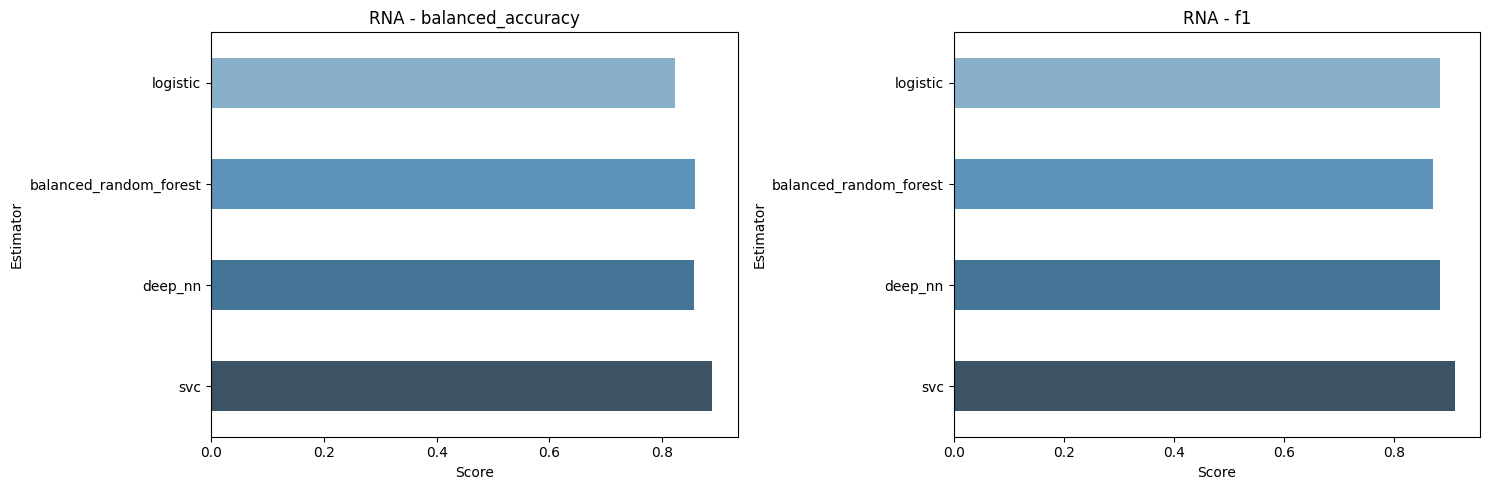

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

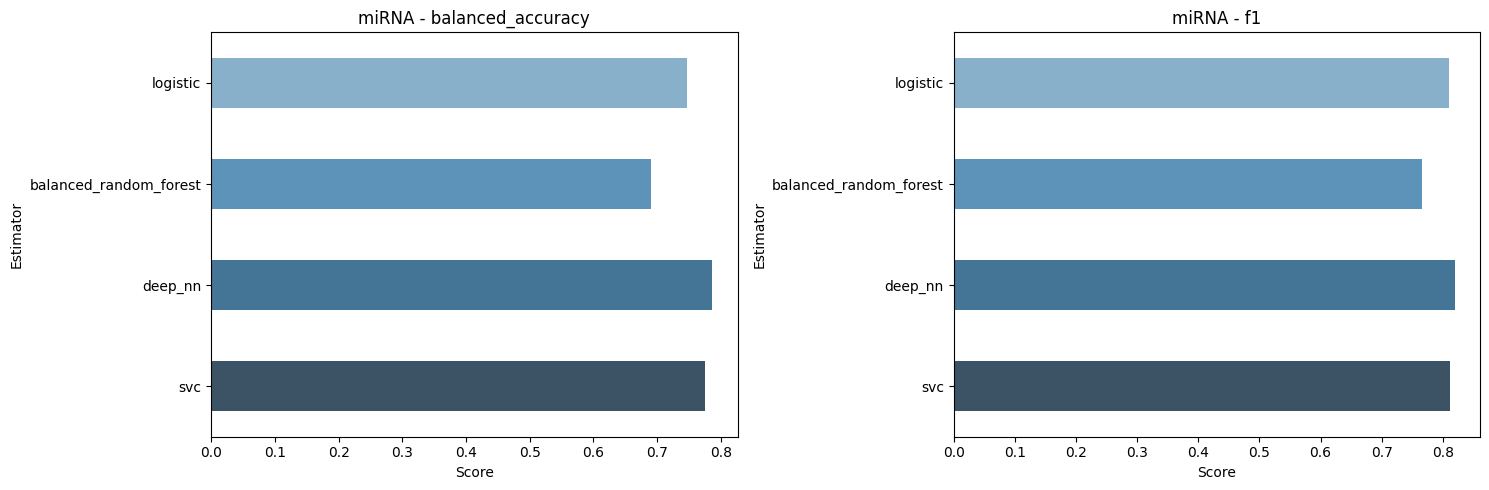

In [ ]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

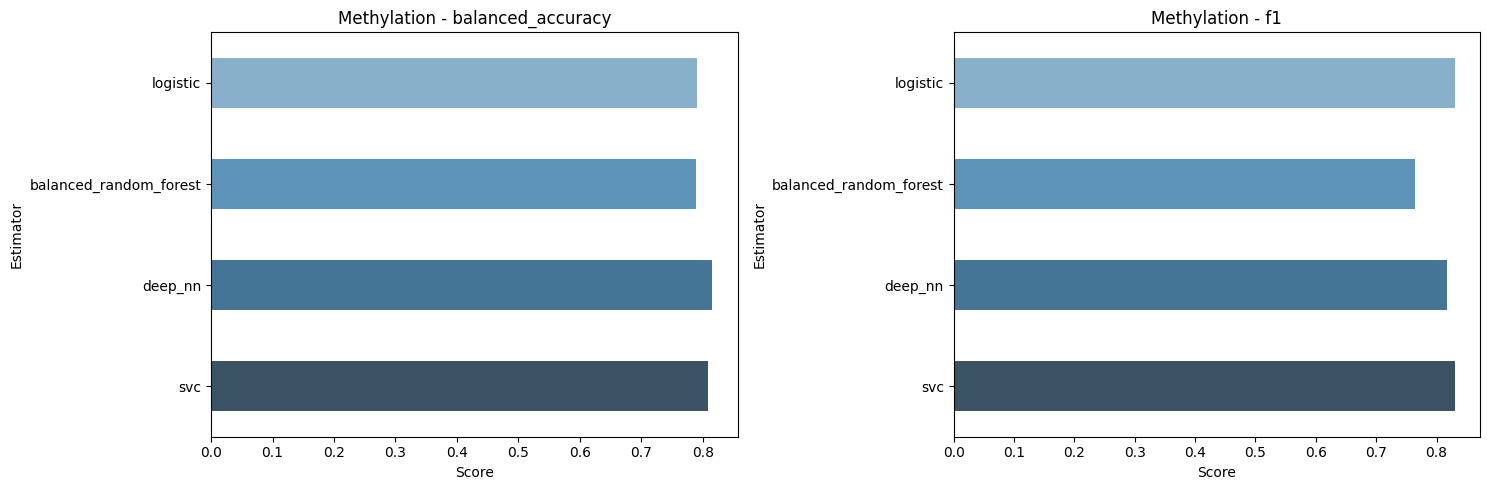

In [ ]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

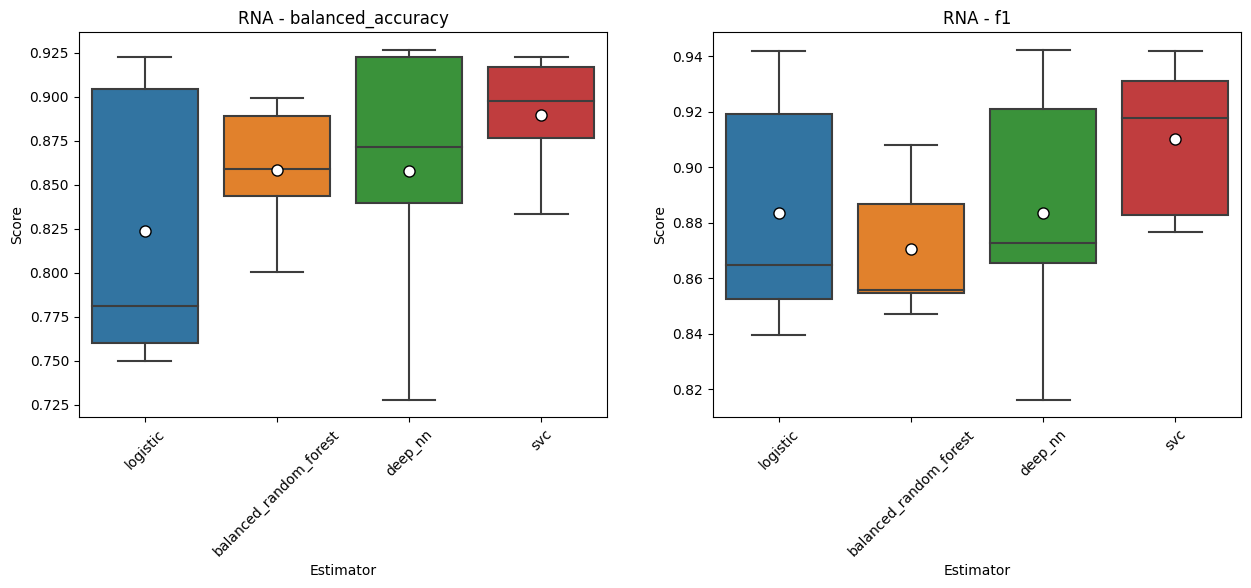

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

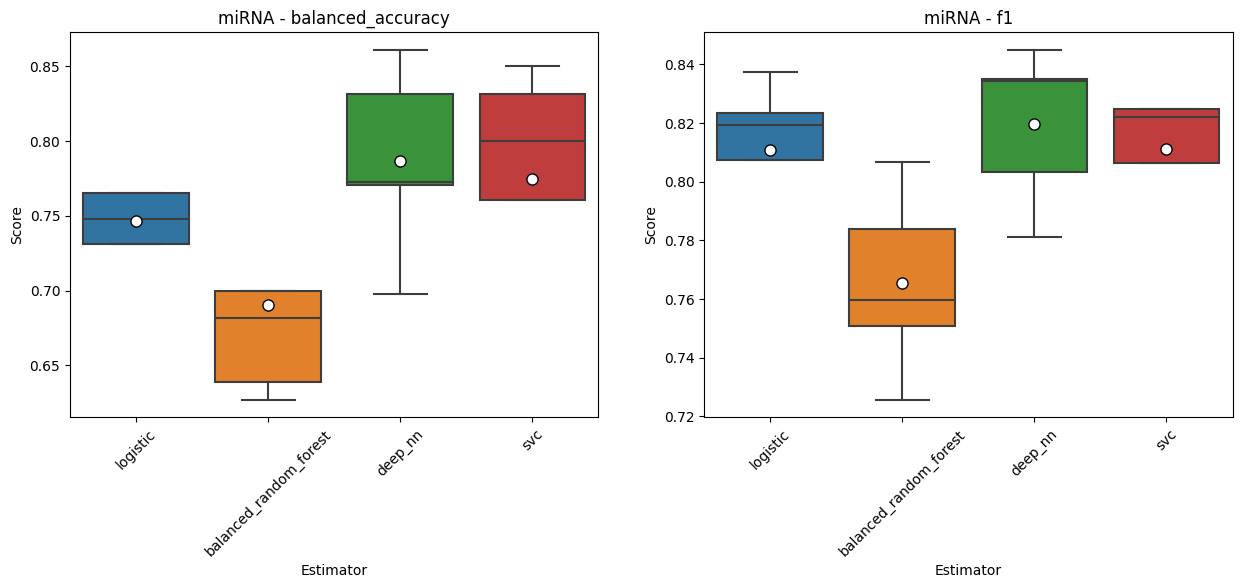

In [ ]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

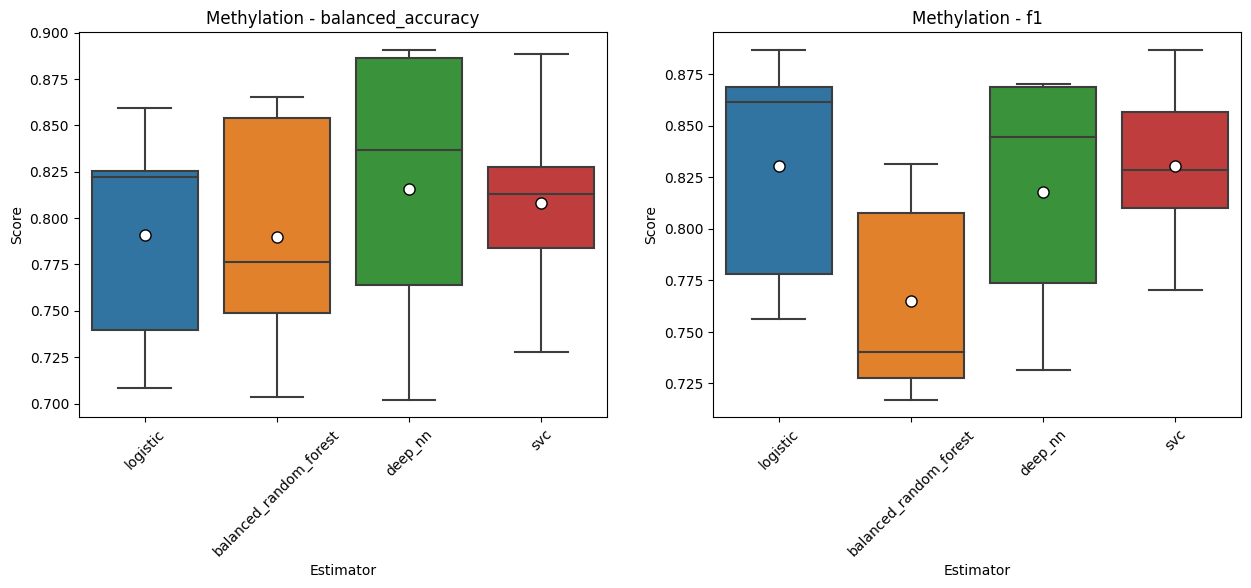

In [ ]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

### Testing significance tests

In [ ]:
from scipy.stats import mannwhitneyu, wilcoxon
stat, p = mannwhitneyu(base_scores['rna'][0]['test_balanced_accuracy'], base_scores['rna'][3]['test_balanced_accuracy'])
print(p)
stat, p = wilcoxon(base_scores['rna'][0]['test_balanced_accuracy'], base_scores['rna'][3]['test_balanced_accuracy'])
print(p)

0.345741825860727
0.06788915486182899


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [ ]:
print(base_scores['mirna'][1])
print(base_scores['mirna'][2])

{'fit_time': array([1.12852001, 1.09547806, 1.10043502, 1.10665011, 1.08517408]), 'score_time': array([0.07238817, 0.07504416, 0.08146596, 0.07807064, 0.07814693]), 'test_accuracy': array([0.76744186, 0.73255814, 0.80232558, 0.79069767, 0.76744186]), 'test_balanced_accuracy': array([0.62707039, 0.63902692, 0.80414079, 0.69981884, 0.68194444]), 'test_f1': array([0.75084553, 0.72564433, 0.80655795, 0.78379558, 0.75961947]), 'test_recall (Basal)': array([0.92857143, 0.92857143, 0.85714286, 1.        , 0.86666667]), 'test_recall (Her2)': array([0.16666667, 0.16666667, 0.83333333, 0.16666667, 0.5       ]), 'test_recall (LumA)': array([0.91304348, 0.76086957, 0.82608696, 0.7826087 , 0.91111111]), 'test_recall (LumB)': array([0.5 , 0.7 , 0.7 , 0.85, 0.45])}
{'fit_time': array([1.49437404, 1.62711287, 1.59691   , 1.56278396, 1.56324887]), 'score_time': array([0.07366896, 0.04335523, 0.05248284, 0.05000114, 0.05397201]), 'test_accuracy': array([0.79069767, 0.80232558, 0.8372093 , 0.8372093 , 0.

In [ ]:
stat, p = mannwhitneyu(base_scores['mirna'][1]['test_recall (Her2)'], base_scores['rna'][2]['test_recall (Her2)'])
print(p)

0.07048462904621097


In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=estimators[0][1],
                          estimator2=estimators[3][1],
                          X=X['rna'], y=y, scoring='balanced_accuracy', random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.272
p value: 0.259


In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=estimators[1][1],
                          estimator2=estimators[2][1],
                          X=X['mirna'], y=y, scoring='balanced_accuracy', random_seed=2)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.431
p value: 0.212


In [ ]:
t, p = paired_ttest_5x2cv(estimator1=estimators[1][1],
                          estimator2=RandomForestClassifier(),
                          X=X['mirna'], y=y, scoring='balanced_accuracy', random_seed=2)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.050
p value: 0.096


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

results_model_1 = cross_val_score(estimators[1][1], X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1), scoring='balanced_accuracy')
results_model_2 = cross_val_score(estimators[2][1], X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1), scoring='balanced_accuracy')
results_model_3 = cross_val_score(RandomForestClassifier(), X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1), scoring='balanced_accuracy')

In [ ]:
print(results_model_1.mean())
print(results_model_2.mean())
print(results_model_3.mean())

0.7329064872325742
0.7653236714975846
0.6076718426501035


In [ ]:
print(results_model_1.mean())
print(results_model_2.mean())
print(results_model_3.mean())

0.7142627099148838
0.7577587991718426
0.6010668428317169


In [ ]:
from scipy.stats import wilcoxon
# Calculate p value
stat, p = wilcoxon(results_model_1, results_model_2, zero_method='zsplit')
print(p)
stat, p = wilcoxon(results_model_1, results_model_3, zero_method='zsplit')
print(p)

0.02734375
0.001953125


In [ ]:
from scipy.stats import wilcoxon
# Calculate p value
stat, p = wilcoxon(results_model_1, results_model_2, zero_method='zsplit')
print(p)
stat, p = wilcoxon(results_model_1, results_model_3, zero_method='zsplit')
print(p)

0.00201416015625
6.103515625e-05


In [ ]:
results_model_1 = cross_val_score(estimators[1][1], X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1), scoring='balanced_accuracy')
results_model_2 = cross_val_score(estimators[2][1], X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=2), scoring='balanced_accuracy')
results_model_3 = cross_val_score(RandomForestClassifier(), X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=3), scoring='balanced_accuracy')

In [ ]:
from scipy.stats import mannwhitneyu

print(results_model_1.mean())
print(results_model_2.mean())
print(results_model_3.mean())

# Calculate p value
stat, p = mannwhitneyu(results_model_1, results_model_2)
print(p)
stat, p = mannwhitneyu(results_model_1, results_model_3)
print(p)

0.7329064872325742
0.770877501725328
0.585628064727035
0.034433234736668046
2.0972605736125682e-05


In [ ]:
results_model_1 = cross_val_score(estimators[1][1], X['mirna'], y, cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=1), scoring='balanced_accuracy')
results_model_2 = cross_val_score(estimators[2][1], X['mirna'], y, cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=1), scoring='balanced_accuracy')

In [ ]:
results_model_3 = cross_val_score(RandomForestClassifier(), X['mirna'], y, cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=1), scoring='balanced_accuracy')

In [ ]:
print(results_model_1.mean())
print(results_model_2.mean())
print(results_model_3.mean())


0.7643181818181819
0.7949621212121213
0.6178977272727273


In [ ]:
from scipy.stats import wilcoxon
# Calculate p value
stat, p = wilcoxon(results_model_1, results_model_2, zero_method='zsplit')
print(p)
stat, p = wilcoxon(results_model_1, results_model_3, zero_method='zsplit')
print(p)

0.287337268352032
8.20159912109375e-05


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


# Modality Ensembles

In [ ]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method

    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])

        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)

        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking

        return model

    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_

        return self

    def predict(self, X):
        return self.model_.predict(X)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [ ]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

            accuracy balanced_accuracy               f1   recall (Basal)  \
rna  0.912 +/- 0.034   0.891 +/- 0.057  0.910 +/- 0.036  0.972 +/- 0.034   

       recall (Her2)    recall (LumA)    recall (LumB)  
rna  0.833 +/- 0.183  0.947 +/- 0.023  0.810 +/- 0.120  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the 

              accuracy balanced_accuracy               f1   recall (Basal)  \
mirna  0.821 +/- 0.022   0.779 +/- 0.041  0.814 +/- 0.026  0.958 +/- 0.057   

         recall (Her2)    recall (LumA)    recall (LumB)  
mirna  0.667 +/- 0.211  0.900 +/- 0.059  0.590 +/- 0.150  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

                    accuracy balanced_accuracy               f1  \
methylation  0.833 +/- 0.053   0.807 +/- 0.063  0.830 +/- 0.057   

              recall (Basal)    recall (Her2)    recall (LumA)  \
methylation  0.958 +/- 0.034  0.733 +/- 0.082  0.886 +/- 0.032   

               recall (LumB)  
methylation  0.650 +/- 0.161  


## Scoring

In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161


In [ ]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['mirna'].append(scores['mirna'])
all_scores['methylation'].append(scores['methylation'])

In [ ]:
all_metrics = {}

# Joining metrics together for visualization
for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['mirna'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.888 +/- 0.036,0.824 +/- 0.074,0.884 +/- 0.040,0.972 +/- 0.034,0.600 +/- 0.226,0.952 +/- 0.017,0.770 +/- 0.121
balanced_random_forest,0.870 +/- 0.023,0.858 +/- 0.035,0.871 +/- 0.023,0.972 +/- 0.034,0.800 +/- 0.125,0.891 +/- 0.045,0.770 +/- 0.103
deep_nn,0.884 +/- 0.044,0.858 +/- 0.073,0.884 +/- 0.044,0.972 +/- 0.034,0.767 +/- 0.249,0.921 +/- 0.046,0.770 +/- 0.098
svc,0.912 +/- 0.024,0.889 +/- 0.032,0.910 +/- 0.026,0.972 +/- 0.034,0.833 +/- 0.105,0.952 +/- 0.017,0.800 +/- 0.110
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.816 +/- 0.017,0.747 +/- 0.061,0.811 +/- 0.024,0.930 +/- 0.062,0.500 +/- 0.279,0.886 +/- 0.056,0.670 +/- 0.117
balanced_random_forest,0.772 +/- 0.024,0.690 +/- 0.063,0.765 +/- 0.028,0.916 +/- 0.052,0.367 +/- 0.267,0.839 +/- 0.063,0.640 +/- 0.146
deep_nn,0.823 +/- 0.023,0.787 +/- 0.056,0.820 +/- 0.024,0.958 +/- 0.057,0.667 +/- 0.211,0.882 +/- 0.052,0.640 +/- 0.102
svc,0.816 +/- 0.031,0.775 +/- 0.077,0.811 +/- 0.039,0.958 +/- 0.057,0.633 +/- 0.287,0.878 +/- 0.053,0.630 +/- 0.103
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.833 +/- 0.050,0.791 +/- 0.057,0.830 +/- 0.053,0.958 +/- 0.034,0.633 +/- 0.067,0.882 +/- 0.045,0.690 +/- 0.156
balanced_random_forest,0.760 +/- 0.045,0.790 +/- 0.062,0.765 +/- 0.046,0.945 +/- 0.050,0.800 +/- 0.245,0.733 +/- 0.053,0.680 +/- 0.163
deep_nn,0.823 +/- 0.051,0.816 +/- 0.073,0.818 +/- 0.055,0.958 +/- 0.034,0.833 +/- 0.149,0.882 +/- 0.061,0.590 +/- 0.150
svc,0.830 +/- 0.040,0.808 +/- 0.053,0.830 +/- 0.040,0.972 +/- 0.034,0.700 +/- 0.125,0.860 +/- 0.049,0.700 +/- 0.084
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161


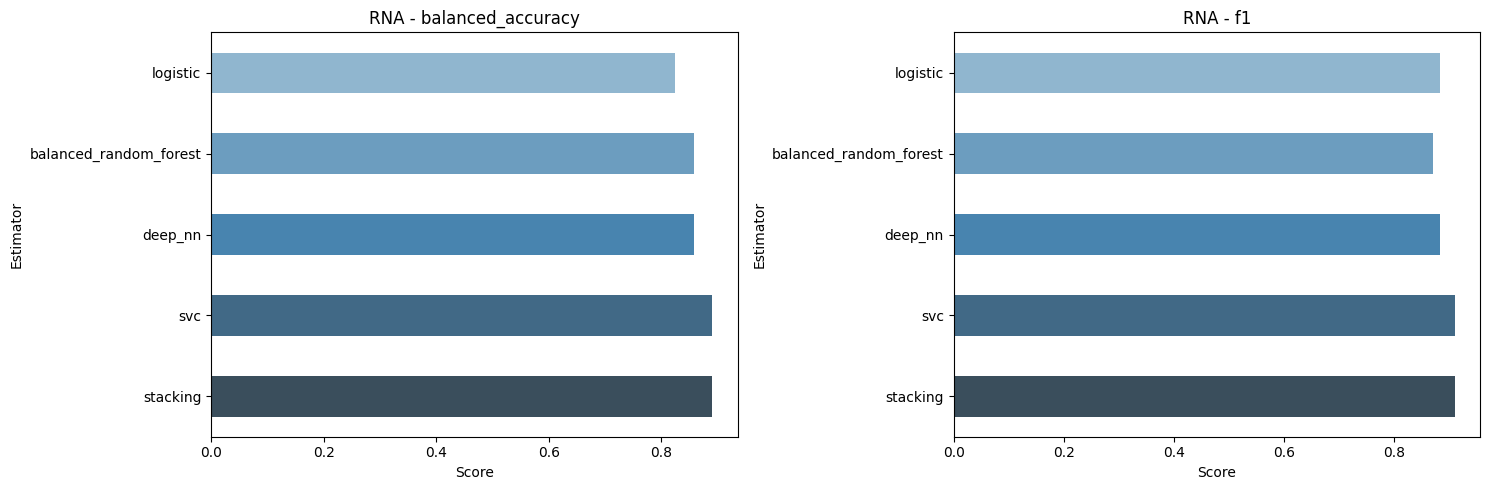

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

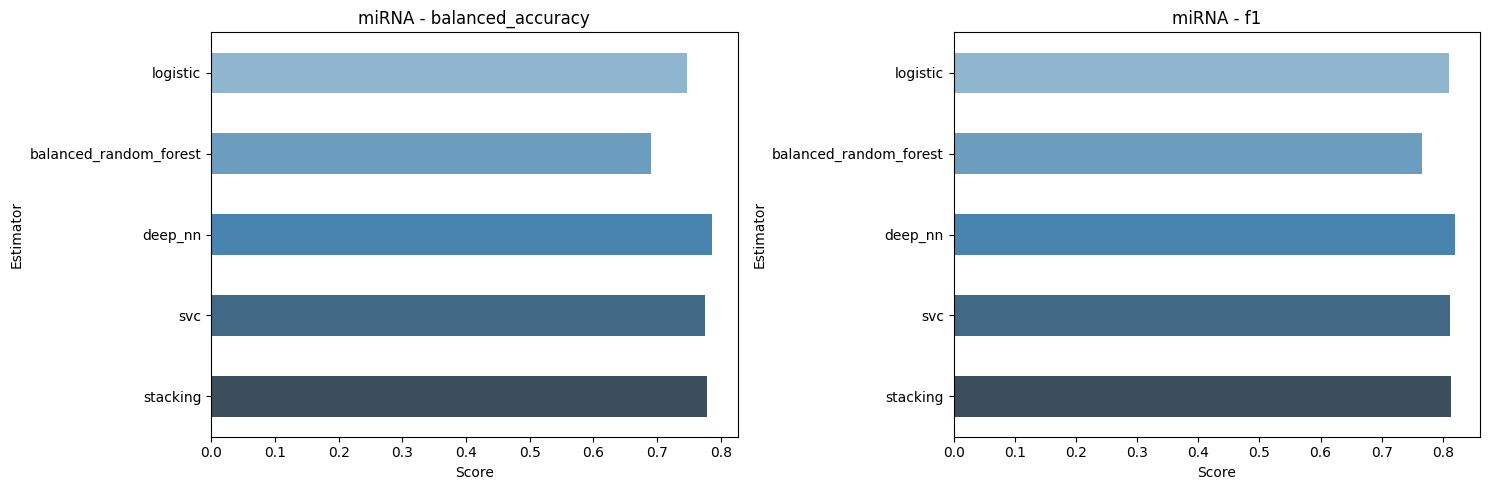

In [ ]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

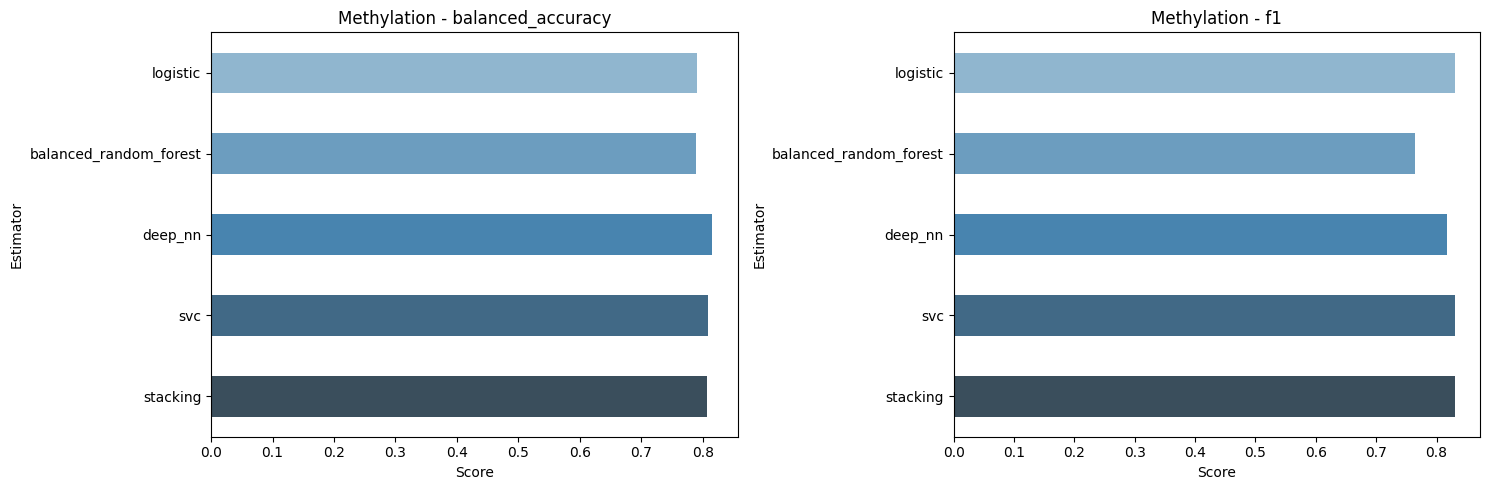

In [ ]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

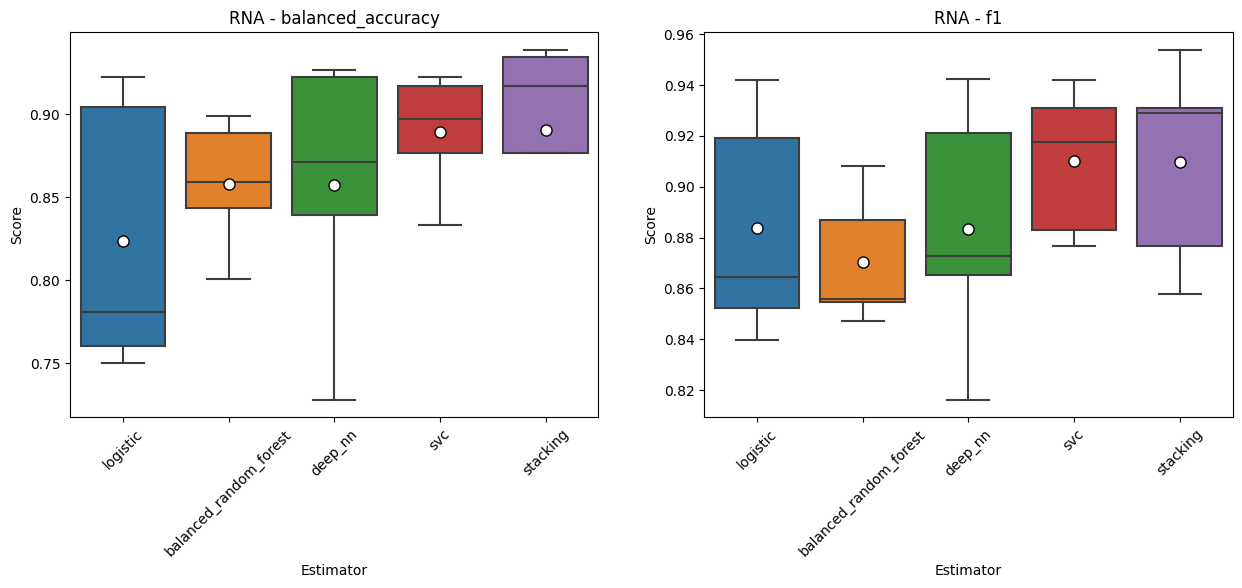

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

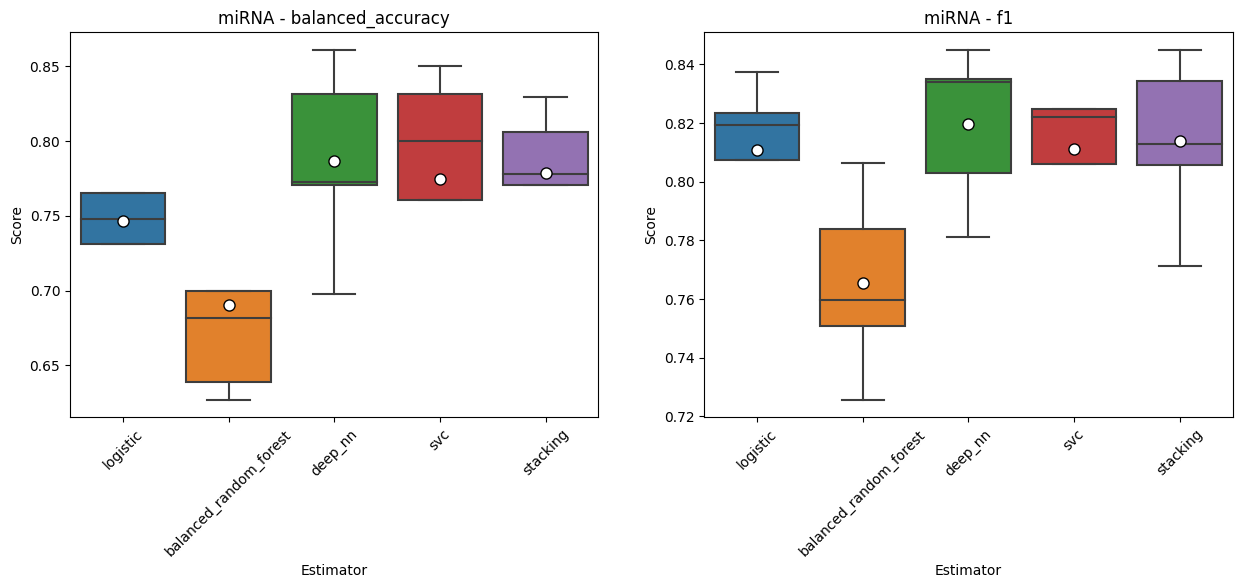

In [ ]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

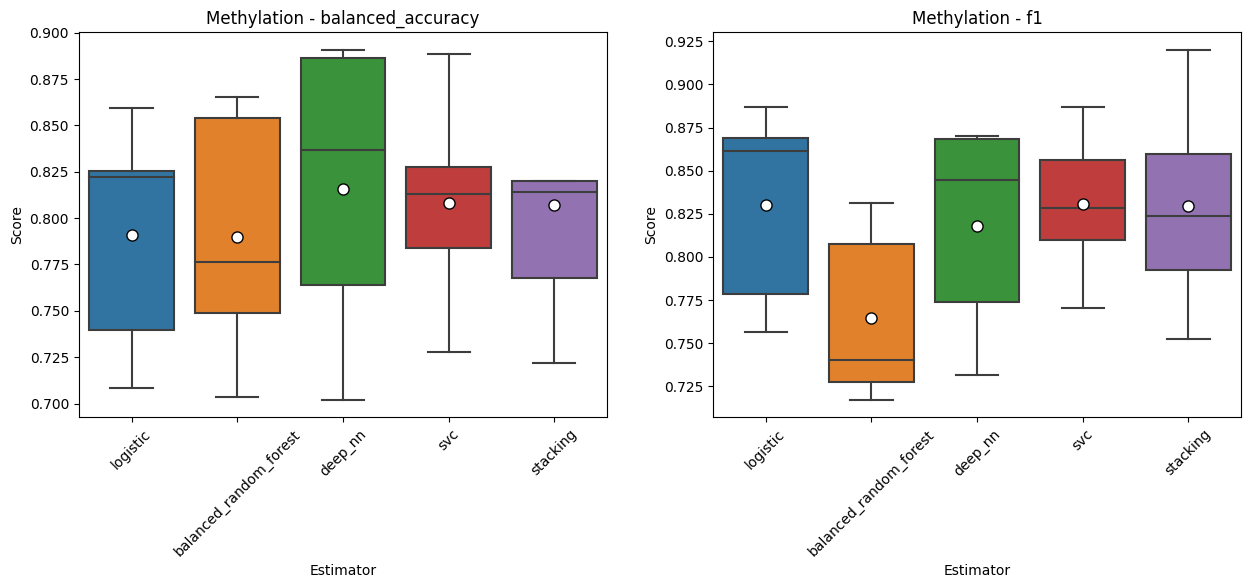

In [ ]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

## Testing Significance

In [ ]:
def wilcoxen_test(estimator1, estimator2, X, y, scoring='balanced_accuracy', n_splits=5, n_repeats=2, random_state=1):

    results_model_1 = cross_val_score(estimator1, X, y, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state), scoring=scoring)
    results_model_2 = cross_val_score(estimator2, X, y, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state), scoring=scoring)

    stat, p = wilcoxon(results_model_1, results_model_2)

    return results_model_1, results_model_2, p

In [ ]:
def wilcoxen_test(estimator1, estimator2, X, y, scoring='balanced_accuracy', n_splits=5, n_repeats=2, random_state=1):

    results_model_1 = cross_validate(estimator1, X, y, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state), scoring=scoring)
    results_model_2 = cross_validate(estimator2, X, y, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state), scoring=scoring)

    stat = {}
    p = {}

    for name, metric in scoring.items():
        stat[name], p[name] = wilcoxon(results_model_1['test_' + name], results_model_2['test_' + name])

    return results_model_1, results_model_2, stat, p

In [ ]:
test_scores, test_metrics = get_cross_metrics(estimators[1][1], X['mirna'], y, 'mirna', scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)}, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1))

In [ ]:
results_svc, results_stacking, stat, p = wilcoxen_test(estimators[1][1], estimators[2][1], X['mirna'], y, scoring={'balanced_accuracy':'balanced_accuracy', 'f1': make_scorer(f1_score, average='weighted')}, n_splits=5, n_repeats=2, random_state=1)

In [ ]:
stat, p

({'balanced_accuracy': 6.0, 'f1': 0.0},
 {'balanced_accuracy': 0.02734375, 'f1': 0.001953125})

# Multi Omics Integration Ensemble

## Cross Val Predict

In [ ]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method='predict_proba')

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

In [ ]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'mirna': preds['mirna'].argmax(axis=1),
    'methylation': preds['methylation'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_basal', 'rna_her2', 'rna_lumA', 'rna_lumB']), pd.DataFrame(preds['mirna'], columns=['mirna_basal', 'mirna_her2', 'mirna_lumA', 'mirna_lumB']), pd.DataFrame(preds['methylation'], columns=['meth_basal', 'meth_her2', 'meth_lumA', 'meth_lumB'])], axis=1)

In [ ]:
preds_class_df

,rna,mirna,methylation
0,2,2,2
1,2,2,2
2,3,3,3
3,2,2,3
4,2,2,2
...,...,...,...
425,2,2,2
426,2,2,2
427,0,0,0
428,2,2,2


In [ ]:
preds_proba_df

,rna_basal,rna_her2,rna_lumA,rna_lumB,mirna_basal,mirna_her2,mirna_lumA,mirna_lumB,meth_basal,meth_her2,meth_lumA,meth_lumB
0,0.001143,0.003336,0.976604,0.018917,0.000965,0.007425,0.936618,0.054992,0.000571,0.004731,0.899763,0.094935
1,0.002274,0.023548,0.754869,0.219310,0.000679,0.028143,0.772848,0.198330,0.000499,0.046152,0.508209,0.445140
2,0.002819,0.031507,0.140681,0.824993,0.003107,0.047067,0.261243,0.688583,0.001642,0.031563,0.129360,0.837435
3,0.000761,0.006209,0.880765,0.112265,0.000393,0.015103,0.829537,0.154966,0.000206,0.032610,0.251901,0.715283
4,0.001515,0.001673,0.979863,0.016950,0.001058,0.006032,0.955120,0.037790,0.000939,0.003289,0.912725,0.083048
...,...,...,...,...,...,...,...,...,...,...,...,...
425,0.000851,0.006070,0.840764,0.152315,0.000321,0.009795,0.908611,0.081273,0.000197,0.009366,0.648421,0.342015
426,0.002147,0.003621,0.940114,0.054118,0.001472,0.011353,0.897932,0.089244,0.001206,0.004896,0.854377,0.139521
427,0.988731,0.010389,0.000335,0.000546,0.983223,0.006663,0.000084,0.010030,0.973780,0.022688,0.000140,0.003392
428,0.001717,0.003275,0.965558,0.029450,0.003985,0.003861,0.887546,0.104608,0.000733,0.002724,0.884764,0.111780


### With Voting

Hard Voting:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score

def calculate_voting_scores(preds_class_df, y, name):
    # Find the majority class for each sample
    majority_class = preds_class_df.mode(axis=1)[0]

    # Calculate the scores
    accuracy = accuracy_score(y, majority_class)
    balanced_accuracy = balanced_accuracy_score(y, majority_class)
    f1 = f1_score(y, majority_class, average='weighted')
    recall = recall_score(y, majority_class, average=None)

    # Create a DataFrame with the scores
    scores_df = pd.DataFrame({
        'accuracy': [accuracy],
        'balanced_accuracy': [balanced_accuracy],
        'f1': [f1],
        'recall (Basal)': [recall[0]],
        'recall (Her2)': [recall[1]],
        'recall (LumA)': [recall[2]],
        'recall (LumB)': [recall[3]]
    })

    return scores_df.rename(index={0: name})

In [ ]:
rna_mirna_meth = calculate_voting_scores(preds_class_df, y, 'rna_mirna_meth')
mirna_meth = calculate_voting_scores(preds_class_df[['mirna', 'methylation']], y, 'mirna_meth')
rna_meth = calculate_voting_scores(preds_class_df[['rna', 'methylation']], y, 'rna_meth')
rna_mirna = calculate_voting_scores(preds_class_df[['rna', 'mirna']], y, 'rna_mirna')

In [ ]:
# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, rna_mirna_meth, mirna_meth, rna_meth, rna_mirna])
integration_voting_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161
rna_mirna_meth,0.890698,0.869599,0.889046,0.971831,0.833333,0.943231,0.73
mirna_meth,0.827907,0.787616,0.813162,0.971831,0.766667,0.951965,0.46
rna_meth,0.867442,0.833132,0.860417,0.971831,0.8,0.960699,0.6
rna_mirna,0.855814,0.832299,0.845404,0.971831,0.866667,0.960699,0.53


### With Stacking

In [ ]:
integration_scores, integration_metrics = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_class_df, y, name='Integration Model', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


In [ ]:
integration_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
Integration Model,0.886 +/- 0.025,0.811 +/- 0.031,0.881 +/- 0.026,0.972 +/- 0.034,0.533 +/- 0.125,0.947 +/- 0.023,0.790 +/- 0.116


In [ ]:
rna_mirna_meth_scores, rna_mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
mirna_meth_scores, mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['mirna_basal', 'mirna_her2', 'mirna_lumA', 'mirna_lumB', 'meth_basal', 'meth_her2', 'meth_lumA', 'meth_lumB']], y, name='mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
rna_meth_scores, rna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_basal', 'rna_her2', 'rna_lumA', 'rna_lumB', 'meth_basal', 'meth_her2', 'meth_lumA', 'meth_lumB']], y, name='rna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
rna_mirna_scores, rna_mirna_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_basal', 'rna_her2', 'rna_lumA', 'rna_lumB', 'mirna_basal', 'mirna_her2', 'mirna_lumA', 'mirna_lumB']], y, name='rna + mirna', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [ ]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_mirna_meth_df, mirna_meth_df, rna_meth_df, rna_mirna_df])

In [ ]:
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161
rna + mirna + methylation,0.909 +/- 0.020,0.896 +/- 0.029,0.908 +/- 0.022,0.972 +/- 0.034,0.867 +/- 0.125,0.943 +/- 0.023,0.800 +/- 0.105
mirna + methylation,0.830 +/- 0.037,0.796 +/- 0.044,0.826 +/- 0.038,0.958 +/- 0.057,0.700 +/- 0.125,0.895 +/- 0.059,0.630 +/- 0.121
rna + methylation,0.916 +/- 0.020,0.902 +/- 0.029,0.915 +/- 0.022,0.972 +/- 0.034,0.867 +/- 0.125,0.948 +/- 0.018,0.820 +/- 0.112
rna + mirna,0.912 +/- 0.024,0.885 +/- 0.026,0.910 +/- 0.025,0.972 +/- 0.034,0.800 +/- 0.125,0.947 +/- 0.023,0.820 +/- 0.121


In [ ]:
names = ['rna', 'mirna', 'methylation', 'rna + mirna + meth', 'mirna + meth', 'rna + meth', 'rna + mirna']
integration = []
integration.append(scores['rna'])
integration.append(scores['mirna'])
integration.append(scores['methylation'])
integration.append(rna_mirna_meth_scores)
integration.append(mirna_meth_scores)
integration.append(rna_meth_scores)
integration.append(rna_mirna_scores)

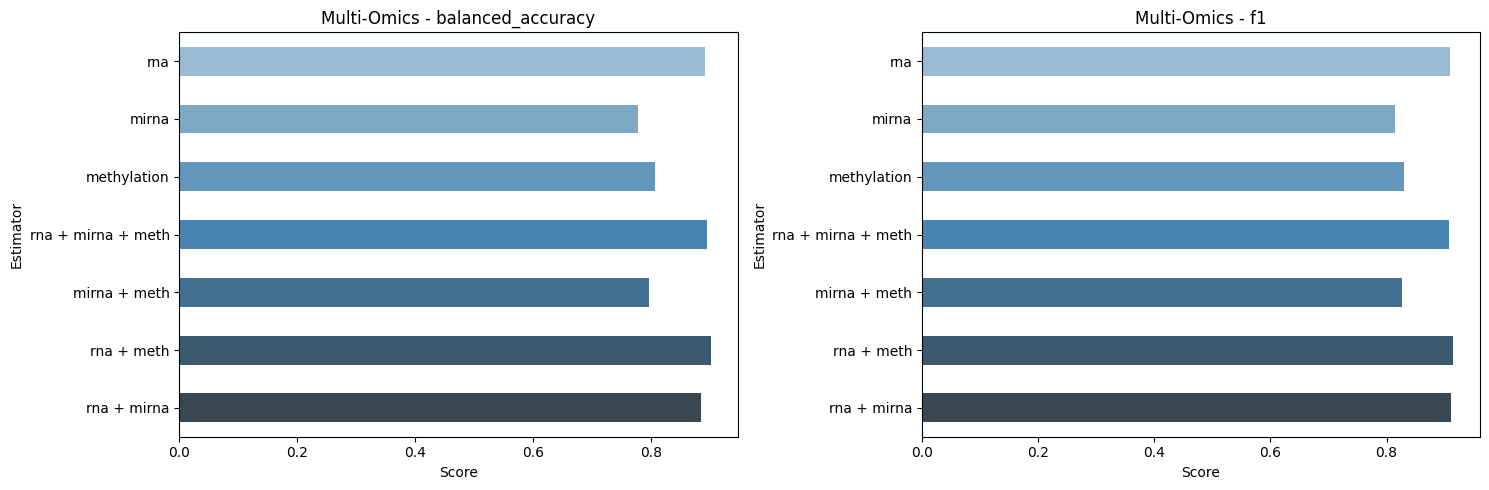

In [ ]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

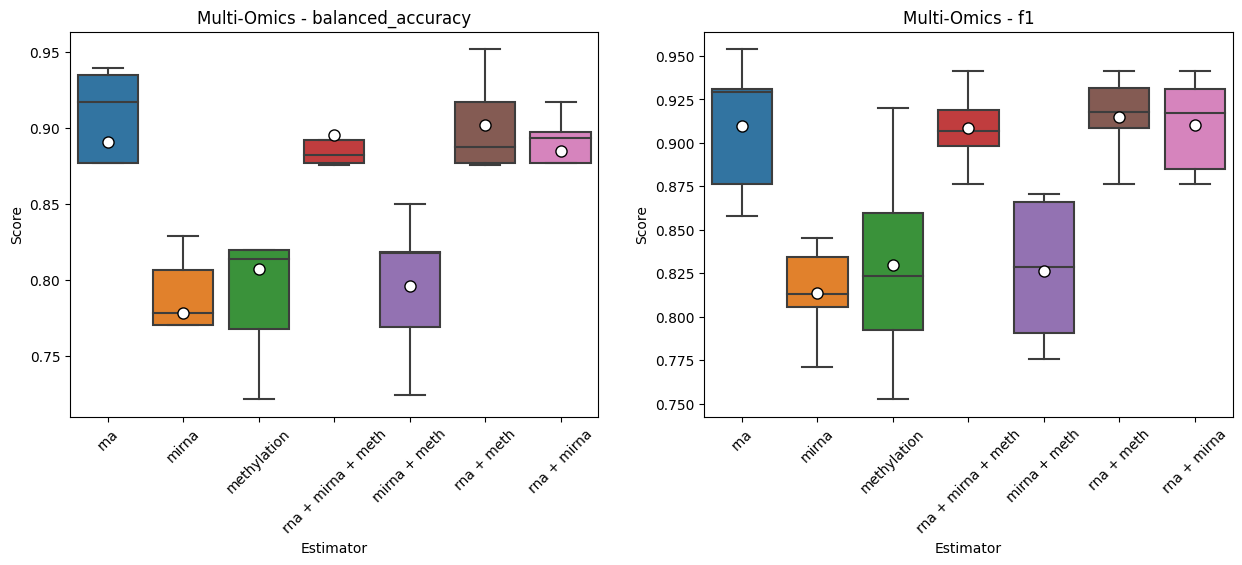

In [ ]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Ensemble Model as a Custom Classifier

In [ ]:
from mlxtend.feature_selection import ColumnSelector

class MultiOmicsIntegrationClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_dict=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), stack_method='auto', cv=5, n_jobs=-1):
        # calculating scores
        self.estimator_dict = estimator_dict
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.stack_method = stack_method
        self.cv = cv
        self.n_jobs = n_jobs

    def _get_pipeline(self):
        self.classifiers_ = []
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)

        for dataset, columns in self.column_names_.items():
            stacking = Pipeline([('column_selector', ColumnSelector(cols=columns)), ('modality_clf', self.estimator_dict[dataset])])
            self.classifiers_.append((dataset, stacking))

        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final_estimator', self.final_estimator)])
        stacking = StackingClassifier(estimators=self.classifiers_, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)

        return stacking

    def fit(self, X, y, column_names=None, **fit_params):

        self.column_names_ = column_names

        self.pipeline_ = self._get_pipeline()
        self.pipeline_.fit(X, y)

        return self

    def predict(self, X):
        return self.pipeline_.predict(X)

    def predict_proba(self, X):
        return self.pipeline_.predict_proba(X)

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + mirna + meth'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['mirna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['mirna', 'methylation']}, cv=3)
meta_ensembles['rna + mirna'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'mirna']}, cv=3)
meta_ensembles['rna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'methylation']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + mirna + meth'] = pd.concat([X['rna'], X['mirna'], X['methylation']], axis=1, join='inner')
X_merged['mirna + meth'] = pd.concat([X['mirna'], X['methylation']], axis=1, join='inner')
X_merged['rna + mirna'] = pd.concat([X['rna'], X['mirna']], axis=1, join='inner')
X_merged['rna + meth'] = pd.concat([X['rna'], X['methylation']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
integration_scores['rna + mirna + meth'], integration_metrics['rna + mirna + meth'] = get_cross_metrics(meta_ensembles['rna + mirna + meth'], X_merged['rna + mirna + meth'], y, name='rna + mirna + meth', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['mirna + meth'], integration_metrics['mirna + meth'] = get_cross_metrics(meta_ensembles['mirna + meth'], X_merged['mirna + meth'], y, name='mirna + meth', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['rna + mirna'], integration_metrics['rna + mirna'] = get_cross_metrics(meta_ensembles['rna + mirna'], X_merged['rna + mirna'], y, name='rna + mirna', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['rna + meth'], integration_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
class_integration_stacking_metrics = pd.concat([modality_metrics, integration_metrics.values()])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

class_integration = []
class_integration.append(scores['rna'])
class_integration.append(scores['cnv'])
class_integration.append(scores['rppa'])

for name, value in integration_scores.items():
    class_integration.append(value)

In [ ]:
class_integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161
rna + mirna + meth,0.912 +/- 0.022,0.897 +/- 0.022,0.910 +/- 0.023,0.972 +/- 0.034,0.867 +/- 0.125,0.947 +/- 0.023,0.800 +/- 0.114
mirna + meth,0.851 +/- 0.021,0.826 +/- 0.031,0.849 +/- 0.020,0.958 +/- 0.057,0.767 +/- 0.133,0.908 +/- 0.054,0.670 +/- 0.081
rna + meth,0.914 +/- 0.020,0.898 +/- 0.027,0.912 +/- 0.022,0.972 +/- 0.034,0.867 +/- 0.125,0.952 +/- 0.017,0.800 +/- 0.105
rna + mirna,0.909 +/- 0.020,0.888 +/- 0.008,0.908 +/- 0.021,0.972 +/- 0.034,0.833 +/- 0.105,0.947 +/- 0.023,0.800 +/- 0.114


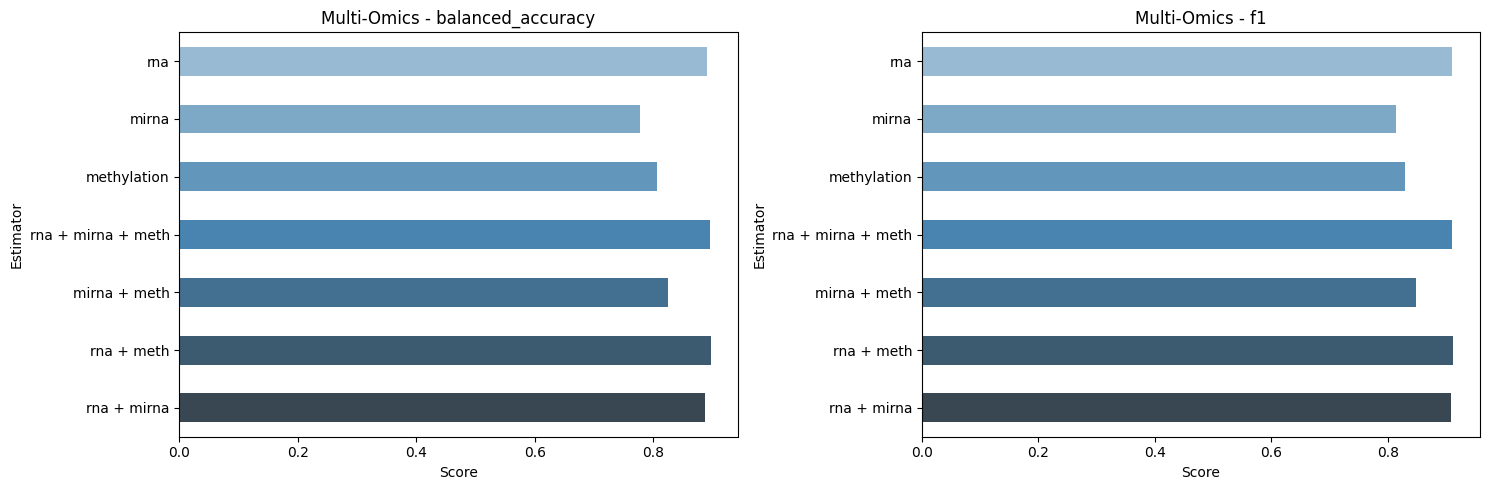

In [ ]:
plot_bar_scores(names, class_integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

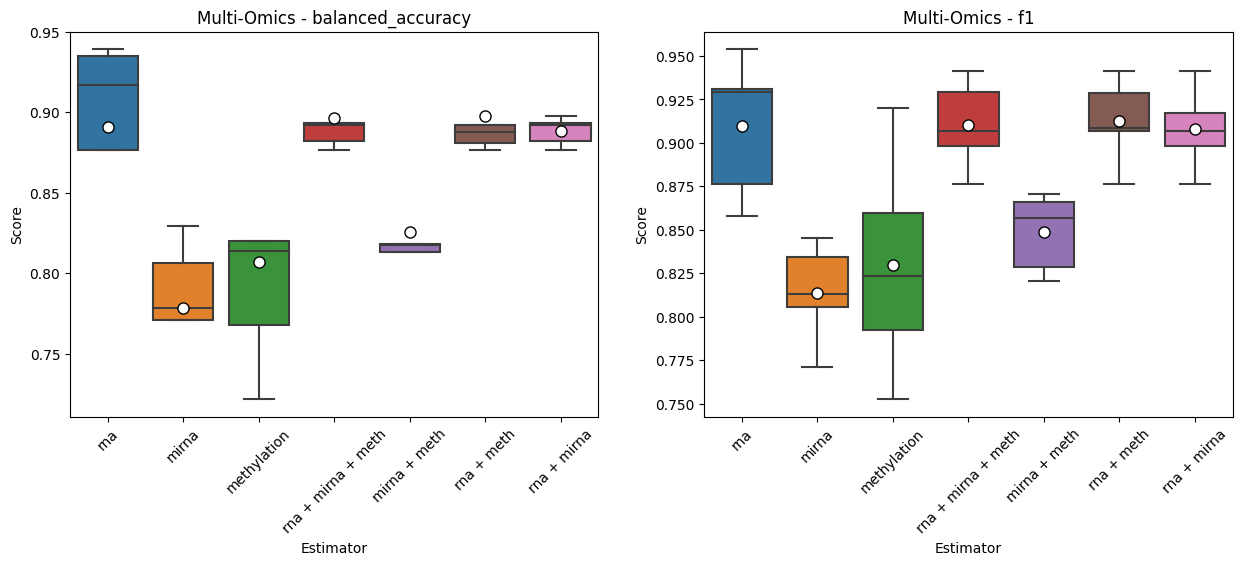

In [ ]:
plot_box_scores(names, class_integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
meta_ensembles['rna + mirna + meth'].fit(X_merged['rna + mirna + meth'], y, column_names=column_names)
meta_ensembles['rna + mirna + meth'].pipeline_

StackingClassifier(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimators=[('rna',
                                Pipeline(steps=[('column_selector',
                                                 ColumnSelector(cols=Index(['A1BG_rna', 'A1CF_rna', 'A2BP1_rna', 'A2LD1_rna', 'A2ML1_rna',
       'A2M_rna', 'A4GALT_rna', 'A4GNT_rna', 'AAA1_rna', 'AAAS_rna',
       ...
       'ZWINT_rna', 'ZXDA_rna', 'ZXDB_rna', 'ZXDC_rna', 'ZYG11A_rna',
       'ZYG11B_rna', 'Z...
                                                                                                    StandardScaler()),
                                                                                                   ('mlpclassifier',
                                                                                                    MLPClassifier(random_state=0))])),
                                                                                  ('svc',
                                                                                   Pipeline(steps=[('standardscaler',
                                                                                                    StandardScaler()),
                                                                                                   ('svc',
                                                                                                    SVC(kernel='linear',
                                                                                                        max_iter=1000,
                                                                                                        random_state=0))]))]))]))],
                   final_estimator=Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('final_estimator',
                                                    LogisticRegression(n_jobs=-1,
                                                                       random_state=0))]),
                   n_jobs=-1)

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [ ]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2)

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
# Picking models we want to compare performances for
compare = [
    ('mirna + meth', 'meth'),
    ('rna + mirna + meth', 'rna')
]

ensemble_results = {}
ensemble_metrics = {}

In [ ]:
ensemble_results['mirna + meth'], ensemble_metrics['mirna + meth'] = get_cross_metrics(meta_ensembles['mirna + meth'], X_merged['mirna + meth'], y, name='mirna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring, fit_params={'column_names': {key: column_names[key] for key in ['mirna', 'methylation']}})
ensemble_results['meth'], ensemble_metrics['meth'] = get_cross_metrics(classifiers['methylation'], X['methylation'], y, name='meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring)


In [ ]:
ensemble_results['rna + mirna + meth'], ensemble_metrics['rna + mirna + meth'] = get_cross_metrics(meta_ensembles['rna + mirna + meth'], X_merged['rna + mirna + meth'], y, name='rna + mirna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring, fit_params={'column_names': column_names})
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring)

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the 

NameError: name 'ensemble_results' is not defined

In [ ]:

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results[est1]['test_' + metric], ensemble_results[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

,estimator_1,estimator_2,statistic,p,significant
0,mirna + meth,meth,20.0,0.021545,True


,estimator_1,estimator_2,statistic,p,significant
0,mirna + meth,meth,11.0,0.003357,True


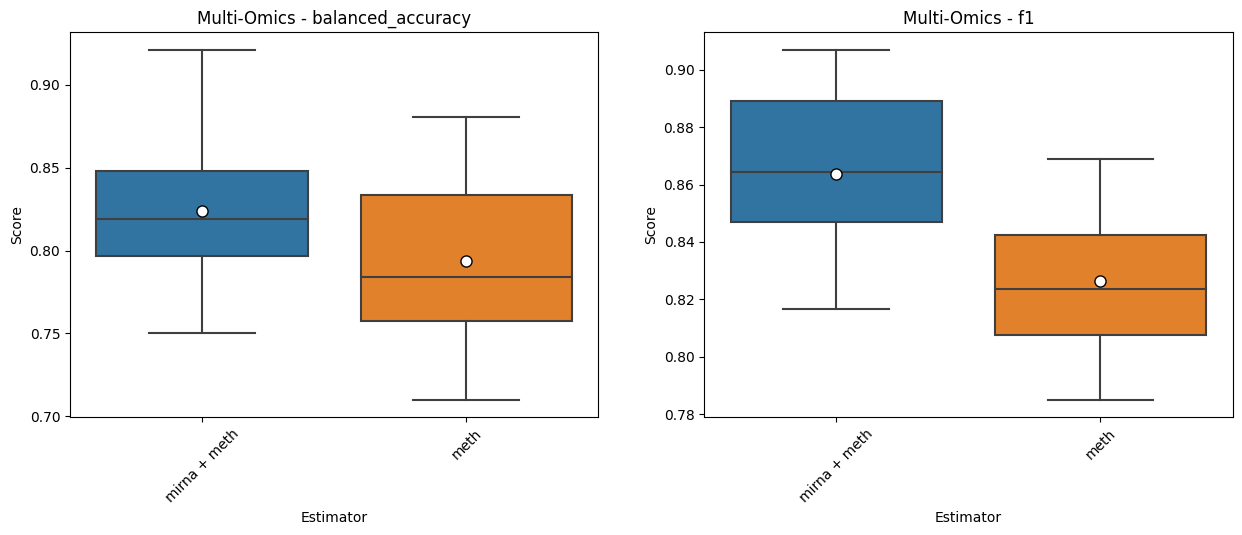

In [ ]:
plot_box_scores(['mirna + meth', 'meth'], [ensemble_results['mirna + meth'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

### Paired t-test

In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

def p_value(estimator_1, estimator_2, X_1, X_2, y, scoring=make_scorer(f1_score, average='weighted'), random_seed=0, fit_params_1=None, fit_params_2=None):
    t, p = paired_ttest_5x2cv_custom(estimator_1[1], estimator_2[1], X_1, X_2, y, scoring=scoring, random_seed=random_seed, fit_params_1=fit_params_1, fit_params_2=fit_params_2)

    significant = p <= 0.05
    results = pd.DataFrame({'estimator_1': estimator_1[0], 'estimator_2': estimator_2[0], 'p': p, 'significant': significant}, index=[0])

    return results

In [ ]:
p_value_mirna_meth = p_value(('mirna + meth', meta_ensemble_mirna_meth), ('mirna', classifiers['mirna']),  pd.concat([X['mirna'], X['methylation']], axis=1, join='inner'), X['mirna'], y, fit_params_1={'column_names': {'mirna': X['mirna'].columns, 'methylation': X['methylation'].columns}})

In [ ]:
p_value_mirna_meth

,estimator_1,estimator_2,p,significant
0,mirna + meth,meth,0.755614,False
